# CS 6140 Machine Learning: Assignment - 1 (Total Points: 100)
## Prof. Ahmad Uzair 

### Q1. Decision Tree Classifier (50 points)

### Q1.1 Growing Decison Trees from scratch (40 points)

Decision Trees (DTs) are a non-parametric supervised learning method used for classification and regression. The goal of this question in the assignment is to create a model that predicts the value of a target variable by learning simple decision rules inferred from the data features.
You must also print the Decision Tree. Use information gain based on entropy as the splitting measure.

Use the data.csv dataset for this particular question. The dataset should be uploaded on Canvas with Assignment 1. Split the dataset into training and test data and calculate testing accuracy.


In [34]:
import pandas
from sklearn.model_selection import train_test_split

import numpy as np
import matplotlib.pyplot as plt


class Utils:

    @staticmethod
    def accuracy(Y, Y_hat):
        count = 0
        for i in range(len(Y)):
            if Y[i] == Y_hat[i]:
                count += 1
        return count / len(Y)


class DecisionTreeNode:
    def __init__(self, X, Y):
        if len(X) == 0:
            return
        self.X = X
        self.Y = Y
        self.isLeaf = False
        self.best = -1
        self.H = self.entropy(Y)
        self.trueChild = None
        self.falseChild = None

        num, freq = np.unique(Y, return_counts=True)
        for i in range(len(freq)):
            if freq[i] == len(Y):
                self.isLeaf = True
                self.best = num[i]
                return

        self.featureIndex, self.compValue = self.findBestSplit()
        tx, ty, fx, fy = self.split(X, Y, self.featureIndex, self.compValue)
        self.trueChild = DecisionTreeNode(tx, ty)
        self.falseChild = DecisionTreeNode(fx, fy)

    def entropy(self, Y):
        num, freq = np.unique(Y, return_counts=True)
        h = 0.0
        for val in freq:
            if val != 0:
                prob = val / len(Y)
                h -= prob * (np.log2(prob))
        return h

    def informationGain(self, X, Y, featureIndex, value):
        tx, ty, fx, fy = self.split(X, Y, featureIndex, value)
        expectedEntropy = 0
        expectedEntropy += (len(ty) / len(Y)) * self.entropy(ty)
        expectedEntropy += (len(fy) / len(Y)) * self.entropy(fy)
        IG = self.H - expectedEntropy
        return IG

    def split(self, X, Y, featureIndex, value):
        tx, ty, fx, fy = [], [], [], []
        for i in range(0, len(X)):
            if X[i][featureIndex] < value:
                tx.append(X[i])
                ty.append(Y[i])
            else:
                fx.append(X[i])
                fy.append(Y[i])
        return np.array(tx), np.array(ty), np.array(fx), np.array(fy)

    def findBestSplit(self):
        copy_X = np.transpose(self.X)
        maxIG = float("-inf")
        bestFeatureIndex = None
        bestValue = None
        for i in range(0, len(copy_X)):
            T = np.sort(copy_X[i])
            for j in range(1, len(T)):
                midValue = (T[j - 1] + T[j]) / 2.0
                currentIG = self.informationGain(self.X, self.Y, i, midValue)
                if currentIG > maxIG:
                    maxIG = currentIG
                    bestFeatureIndex = i
                    bestValue = midValue
        return bestFeatureIndex, bestValue

    def predict(self, X):
        if self.isLeaf:
            return self.best
        elif X[self.featureIndex] <= self.compValue:
            return self.trueChild.predict(X)
        else:
            return self.falseChild.predict(X)

    def __str__(self):
        if self.isLeaf:
            return "class:" + str(self.best)
        else:
            return "feature" + str(self.featureIndex + 1) + " <= " + str(self.compValue)


class DecisionTree:
    def __init__(self):
        self.root = None

    def fit(self, X, Y):
        self.root = DecisionTreeNode(X, Y)
        return

    def print(self, feature_names, class_names):
        self.preOrder(self.root, feature_names, class_names, "|--- ")

    def preOrder(self, root, feature_names, class_names, prev):
        if root == None:
            return
        if root.isLeaf:
            print(prev + "class: " + class_names[root.best])
            return
        print(prev + feature_names[root.featureIndex] + " <= " + str(root.compValue))
        self.preOrder(root.trueChild, feature_names, class_names, "|   " + prev)
        print(prev + feature_names[root.featureIndex] + " >  " + str(root.compValue))
        self.preOrder(root.falseChild, feature_names, class_names, "|   " + prev)

    def predict(self, X):
        Y = []
        for i in range(len(X)):
            Y.append(self.root.predict(X[i]))
        return np.array(Y)

    def accuracy(self, Y, Y_hat):
        count = 0
        for i in range(len(Y)):
            if Y[i] == Y_hat[i]:
                count += 1
        return count / len(Y)


data = pandas.read_csv("data.csv")
X = data.drop("class", axis=1).values
Y = data["class"].values

feature_names = list(data.drop("class", axis=1).columns)
class_names = [str(i) for i in range(0, len(set(Y)))]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y)

dt = DecisionTree()
dt.fit(X_train, Y_train)

dt.print(feature_names, class_names)

Y_test_pred = dt.predict(X_test)
print()
print(f'Testing Accuracy: {Utils.accuracy(Y_test, Y_test_pred) * 100:3.2f}')


|--- feature3 <= 2.45
|   |--- class: 0
|--- feature3 >  2.45
|   |--- feature4 <= 1.75
|   |   |--- feature3 <= 5.05
|   |   |   |--- feature1 <= 4.95
|   |   |   |   |--- feature2 <= 2.45
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- feature2 >  2.45
|   |   |   |   |   |--- class: 2
|   |   |   |--- feature1 >  4.95
|   |   |   |   |--- class: 1
|   |   |--- feature3 >  5.05
|   |   |   |--- feature1 <= 6.05
|   |   |   |   |--- class: 1
|   |   |   |--- feature1 >  6.05
|   |   |   |   |--- class: 2
|   |--- feature4 >  1.75
|   |   |--- class: 2

Testing Accuracy: 94.74


### Q1.2 Decision Tree using Sklearn Library (10 points)

Use the Decision Tree Classifier from the Sklearn Library and use gini index as a splitting measure. Use the data.csv dataset.
Calculate accuracy for this model. 
Print the Decision tree and compare the Decision Trees generated from your code and Sklearn.

In [36]:
from sklearn.tree import DecisionTreeClassifier, export_text

clf = DecisionTreeClassifier(criterion="gini")
clf.fit(X_train, Y_train)

print(export_text(clf, feature_names=feature_names))

Y_test_pred = clf.predict(X_test)
print()
print(f'Testing Accuracy: {Utils.accuracy(Y_test, Y_test_pred) * 100:3.2f}')

|--- feature4 <= 0.80
|   |--- class: 0
|--- feature4 >  0.80
|   |--- feature4 <= 1.75
|   |   |--- feature3 <= 5.05
|   |   |   |--- feature1 <= 4.95
|   |   |   |   |--- feature2 <= 2.45
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- feature2 >  2.45
|   |   |   |   |   |--- class: 2
|   |   |   |--- feature1 >  4.95
|   |   |   |   |--- class: 1
|   |   |--- feature3 >  5.05
|   |   |   |--- feature1 <= 6.05
|   |   |   |   |--- class: 1
|   |   |   |--- feature1 >  6.05
|   |   |   |   |--- class: 2
|   |--- feature4 >  1.75
|   |   |--- class: 2


Testing Accuracy: 94.74


### Q2 Linear Regression (40 points)

Linear regression attempts to model the relationship between two variables by fitting a linear equation to observed data. One variable is considered to be an explanatory variable, and the other is considered to be a dependent variable. 
<br>


## Gradient descent algorithm 
\begin{equation}
\theta^{+} = \theta^{-} + \frac{\alpha}{m} (y_{i} - h(x_{i}) )\bar{x}
\end{equation}

This minimizes the following cost function

\begin{equation}
J(x, \theta, y) = \frac{1}{2m}\sum_{i=1}^{m}(h(x_i) - y_i)^2
\end{equation}

where
\begin{equation}
h(x_i) = \theta^T \bar{x}
\end{equation}

In [37]:
# Do not change the code in this cell
true_slope = 15
true_intercept = 2.4
input_var = np.arange(0.0,100.0)
output_var = true_slope * input_var + true_intercept + 300.0 * np.random.rand(len(input_var))

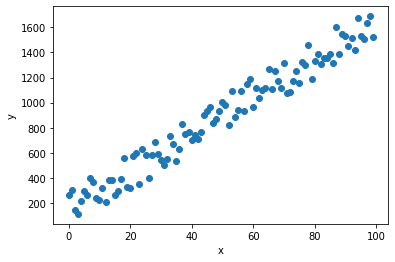

In [39]:
# Do not change the code in this cell
plt.figure()
plt.scatter(input_var, output_var)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [41]:
def compute_cost(ip, op, params):
    """
    Cost function in linear regression where the cost is calculated
    ip: input variables
    op: output variables
    params: corresponding parameters
    Returns cost
    """
    num_samples = len(ip)
    cost_sum = 0.0
    for x,y in zip(ip, op):
        y_hat = np.dot(params, np.array([1.0, x]))
        cost_sum += (y_hat - y) ** 2
    
    cost = cost_sum / (num_samples)
    
    return cost

### Q2.1 Implement Linear Regression using Batch Gradient Descent from scratch.  (15 points)


### Batch gradient descent
Algorithm can be given as follows:

```for j in 0 -> max_iteration: 
    for i in 0 -> m: 
        theta += (alpha / m) * (y[i] - h(x[i])) * x_bar
```

In [8]:
def linear_regression_using_batch_gradient_descent(ip, op, params, alpha, max_iter):
    """
    Compute the params for linear regression using batch gradient descent
    ip: input variables
    op: output variables
    params: corresponding parameters
    alpha: learning rate
    max_iter: maximum number of iterations
    Returns parameters, cost, params_store
    """ 
    # initialize iteration, number of samples, cost and parameter array
    iteration = 0
    num_samples = len(ip)
    cost = np.zeros(max_iter)
    params_store = np.zeros([2, max_iter])
    
    # Compute the cost and store the params for the corresponding cost
    while iteration < max_iter:
        cost[iteration] = compute_cost(ip, op, params)
        params_store[:, iteration] = params
        
        print('--------------------------')
        print(f'iteration: {iteration}')
        print(f'cost: {cost[iteration]}')
        
        
        # Apply batch gradient descent
        None
    
    return params, cost, params_store

In [24]:
# Do not change the code in this cell
# Training the model
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(input_var, output_var, test_size=0.20)

params_0 = np.array([20.0, 80.0])

alpha_batch = 1e-3
max_iter = 100
params_hat_batch, cost_batch, params_store_batch =\
    linear_regression_using_batch_gradient_descent(x_train, y_train, params_0, alpha_batch, max_iter)

--------------------------
iteration: 0
cost: 13192814.727851184
--------------------------
iteration: 1
cost: 22978.459683996098
--------------------------
iteration: 2
cost: 11885.25642780868
--------------------------
iteration: 3
cost: 11964.5078971518
--------------------------
iteration: 4
cost: 11965.559740786983
--------------------------
iteration: 5
cost: 11963.600050005338
--------------------------
iteration: 6
cost: 11961.542961665567
--------------------------
iteration: 7
cost: 11959.483798227724
--------------------------
iteration: 8
cost: 11957.425661469053
--------------------------
iteration: 9
cost: 11955.36865172363
--------------------------
iteration: 10
cost: 11953.31277165639
--------------------------
iteration: 11
cost: 11951.258020754422
--------------------------
iteration: 12
cost: 11949.20439840172
--------------------------
iteration: 13
cost: 11947.151903979264
--------------------------
iteration: 14
cost: 11945.100536868216
--------------------------

### Q2.2 Implement Stochastic Gradient Descent from scratch. (15 points)

### Stochastic Gradient Descent
Algorithm can be given as follows:
```shuffle(x, y)
for i in 0 -> m:
    theta += (alpha / m) * (y[i] - h(x[i])) * x_bar  
```

In [29]:
def lin_reg_stoch_gradient_descent(ip, op, params, alpha):
    """
    Compute the params for linear regression using stochastic gradient descent
    ip: input variables
    op: output variables
    params: corresponding parameters
    alpha: learning rate
    Returns parameters, cost, params_store
    """
    
    # initialize iteration, number of samples, cost and parameter array
    num_samples = len(input_var)
    cost = np.zeros(num_samples)
    params_store = np.zeros([2, num_samples])
    
    i = 0
    # Compute the cost and store the params for the corresponding cost
    for x,y in zip(input_var, output_var):
        cost[i] = compute_cost(input_var, output_var, params)
        params_store[:, i] = params
        
        print('--------------------------')
        print(f'iteration: {i}')
        print(f'cost: {cost[i]}')
        
        # Apply stochastic gradient descent
        None
            
    return params, cost, params_store

In [30]:
# Do not change the code in this cell
alpha = 1e-3
params_0 = np.array([20.0, 80.0])
params_hat, cost, params_store =\
lin_reg_stoch_gradient_descent(x_train, y_train, params_0, alpha)

--------------------------
iteration: 0
cost: 13144888.680606477
--------------------------
iteration: 1
cost: 13144904.387611339
--------------------------
iteration: 2
cost: 13145433.87395811
--------------------------
iteration: 3
cost: 13144673.959294325
--------------------------
iteration: 4
cost: 13144982.09824148
--------------------------
iteration: 5
cost: 13141302.14178
--------------------------
iteration: 6
cost: 13137333.663826264
--------------------------
iteration: 7
cost: 13127653.43123418
--------------------------
iteration: 8
cost: 13118100.471445723
--------------------------
iteration: 9
cost: 13103429.241717
--------------------------
iteration: 10
cost: 13086270.30504895
--------------------------
iteration: 11
cost: 13062221.19901191
--------------------------
iteration: 12
cost: 13041581.498801691
--------------------------
iteration: 13
cost: 13014437.570788614
--------------------------
iteration: 14
cost: 12968631.126795016
--------------------------
itera

### Q2.3 Calculate Root Mean Square error in batch gradient descent algorithm and stochastic gradient descent algorithm (5 points)

In [33]:
# Calculate Root Mean Square error in batch gradient descent algorithm and stochastic gradient descent algorithm


Batch RMS:      93.7947330891927
Stochastic RMS: 125.24063958434985


<IPython.core.display.Javascript object>


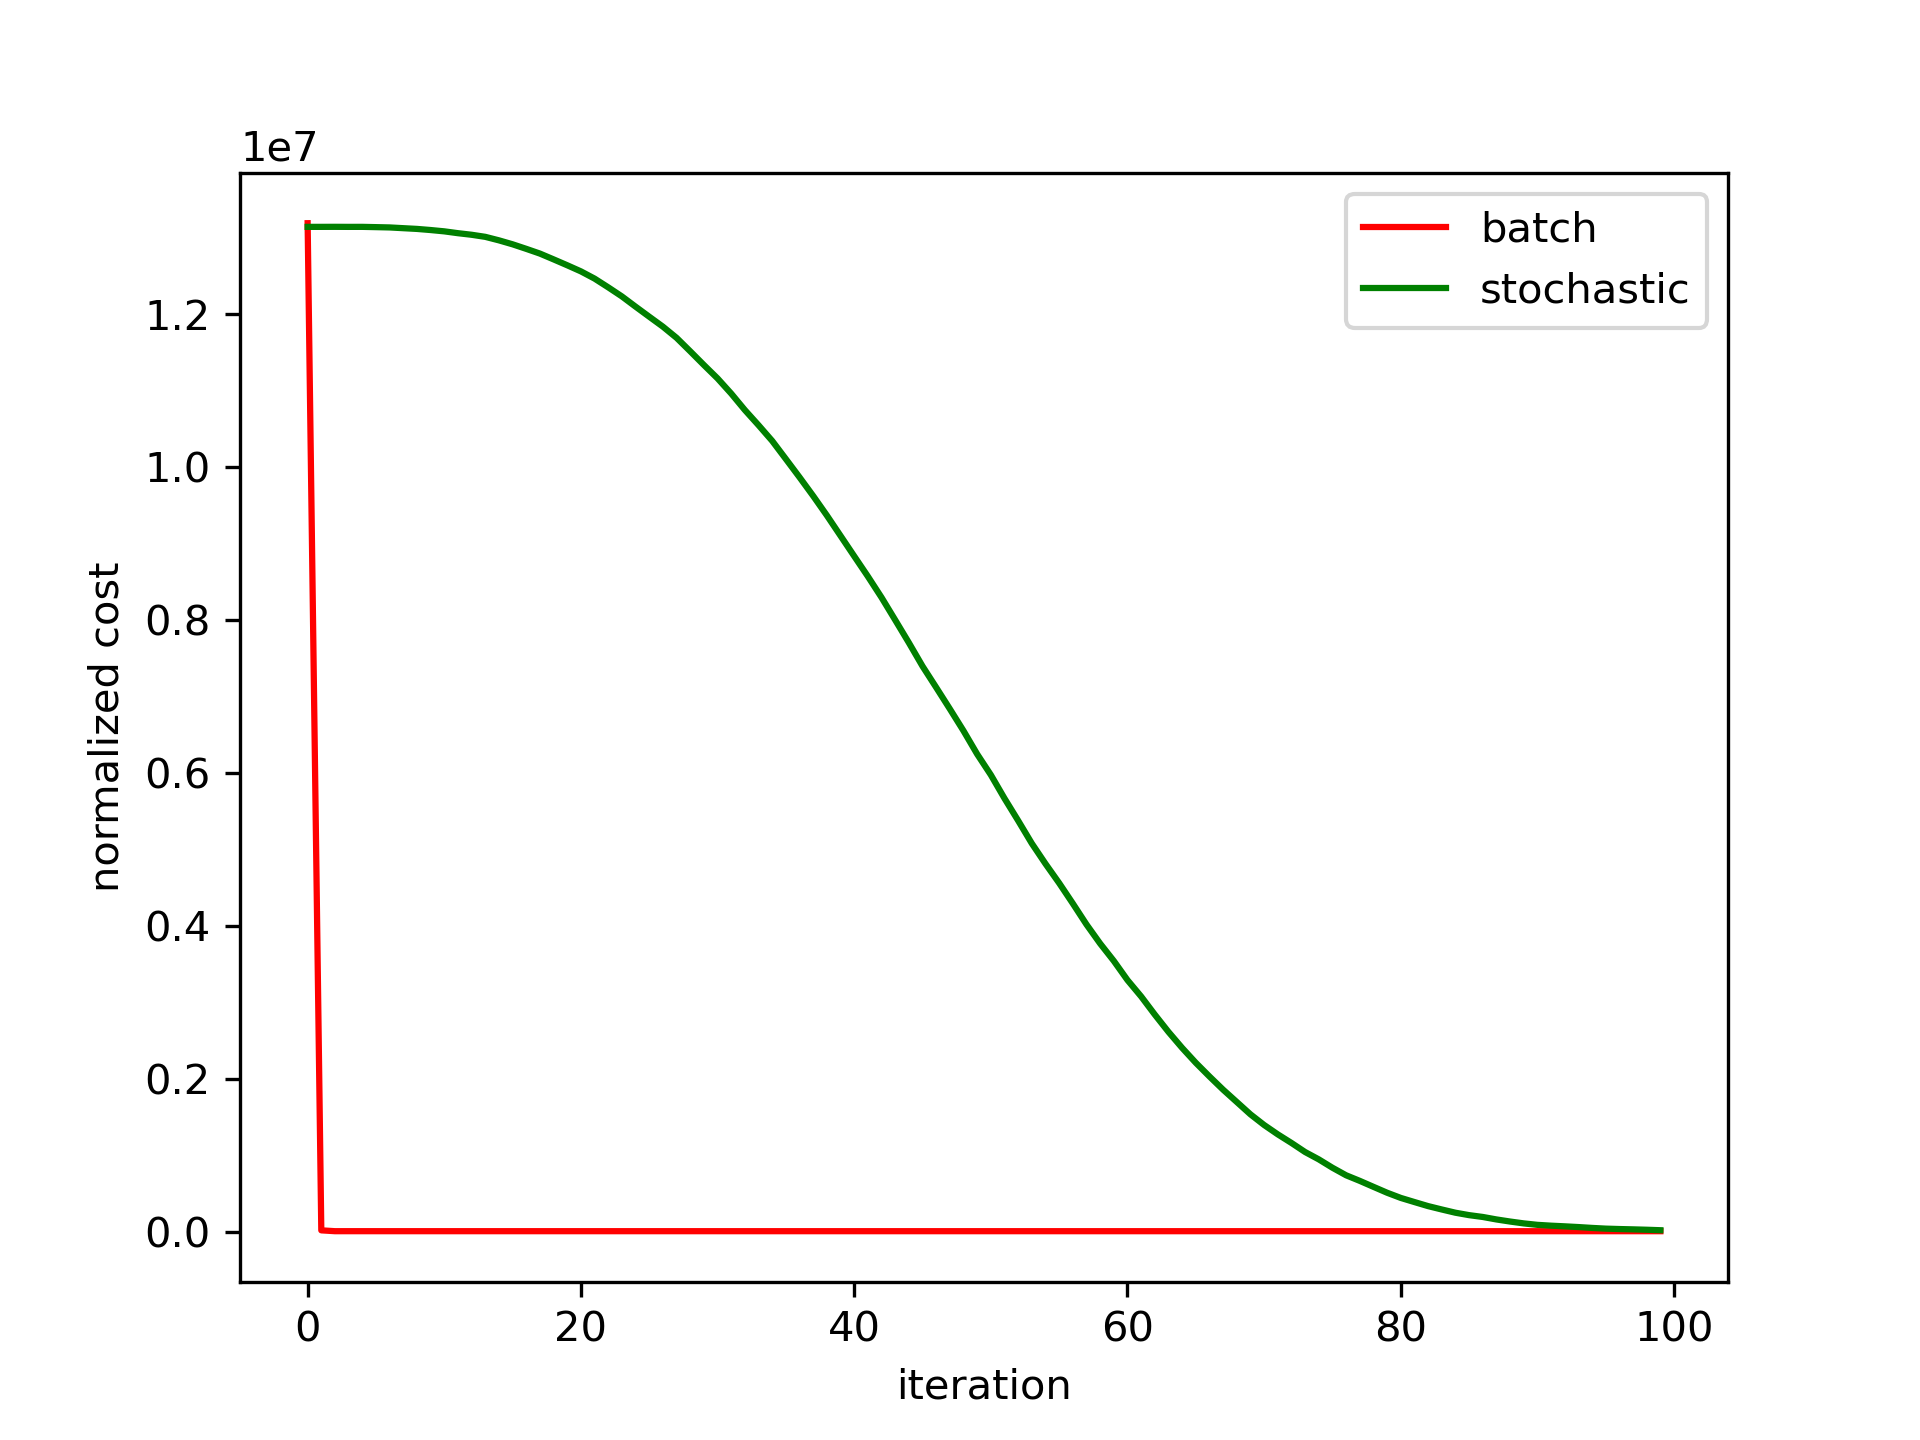

min cost with BGD: 11774.789849230787
min cost with SGD: 24597.82512646985


In [34]:
# Do not change the code in this cell
plt.figure()
plt.plot(np.arange(max_iter), cost_batch, 'r', label='batch')
plt.plot(np.arange(len(cost)), cost, 'g', label='stochastic')
plt.xlabel('iteration')
plt.ylabel('normalized cost')
plt.legend()
plt.show()
print(f'min cost with BGD: {np.min(cost_batch)}')
print(f'min cost with SGD: {np.min(cost)}')

### Q2.4 Which linear regression model do you think works best for this data? Explain in brief. (5 points)

### Q3. Linear Regression Analytical Problem (10 points)
Consider the following training data.

| X1 | X2 | Y |
| -- | -- | -- |
| 0 | 0 | 0 |
| 0 | 1 | 1.5 |
| 1 | 0 | 2 |
| 1 | 1 | 2.5 |
Suppose the data comes from a model y = $θ_{0}$ +$θ_{1}$x1 +$θ_{2}$x2 for unknown constants $θ_{0}$,$θ_{1}$,$θ_{2}$. Use least squares linear regression to find an estimate of $θ_{0}$,$θ_{1}$,$θ_{2}$.